<a href="https://colab.research.google.com/github/RIPS-2024-Aerospace/Aerospace-Project/blob/main/BhattacharyaDistance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!git clone https://github.com/RIPS-2024-Aerospace/Aerospace-Project.git

Cloning into 'Aerospace-Project'...
remote: Enumerating objects: 253, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 253 (delta 64), reused 61 (delta 22), pack-reused 120
Receiving objects: 100% (253/253), 12.25 MiB | 24.17 MiB/s, done.
Resolving deltas: 100% (104/104), done.


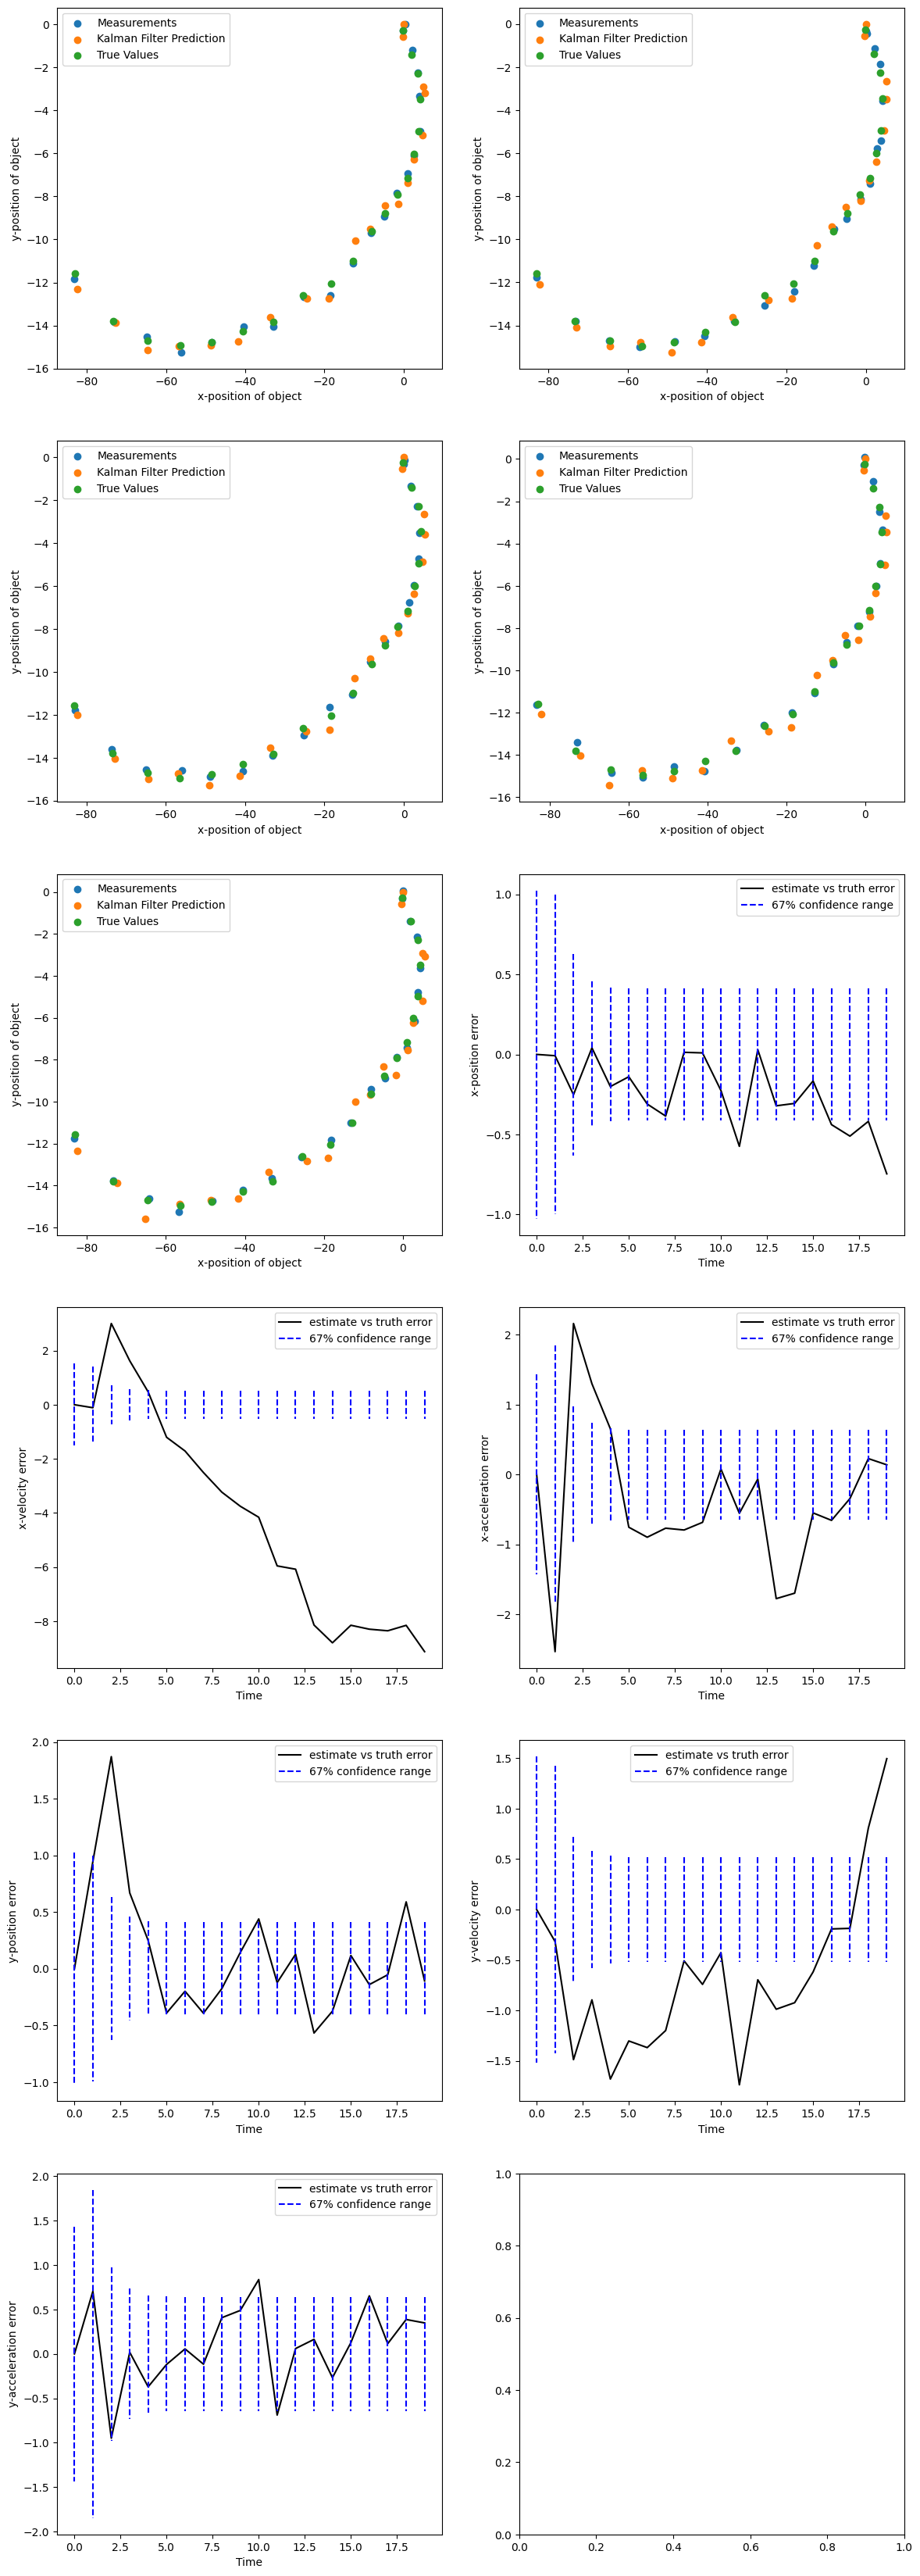

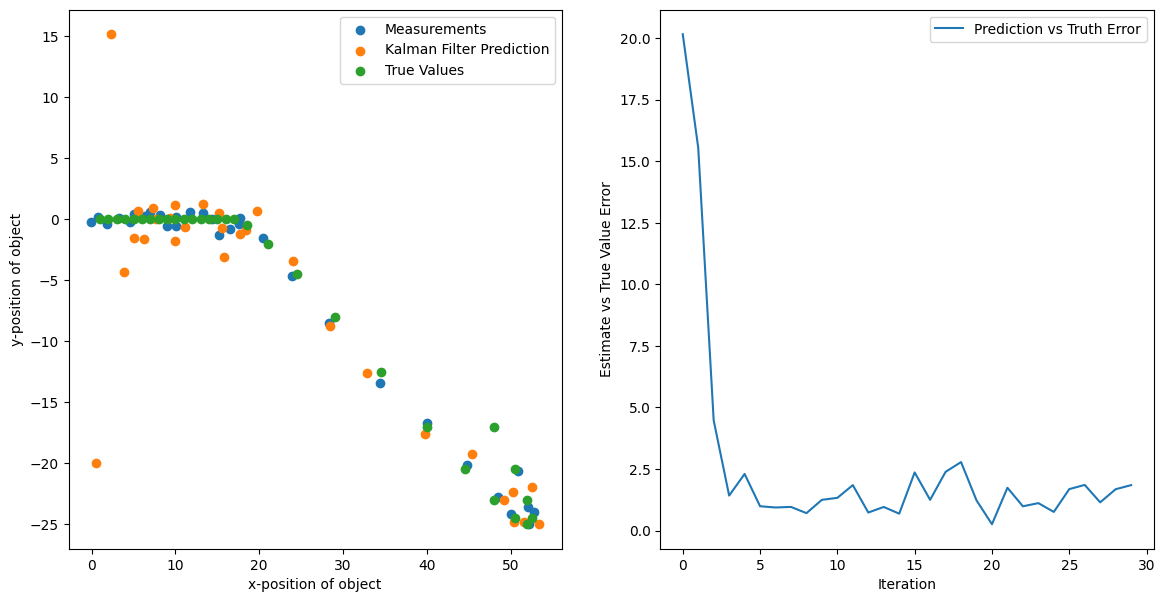

interactive(children=(FloatSlider(value=0.2, description='Measure Var', max=1.0, step=0.01), FloatSlider(value…

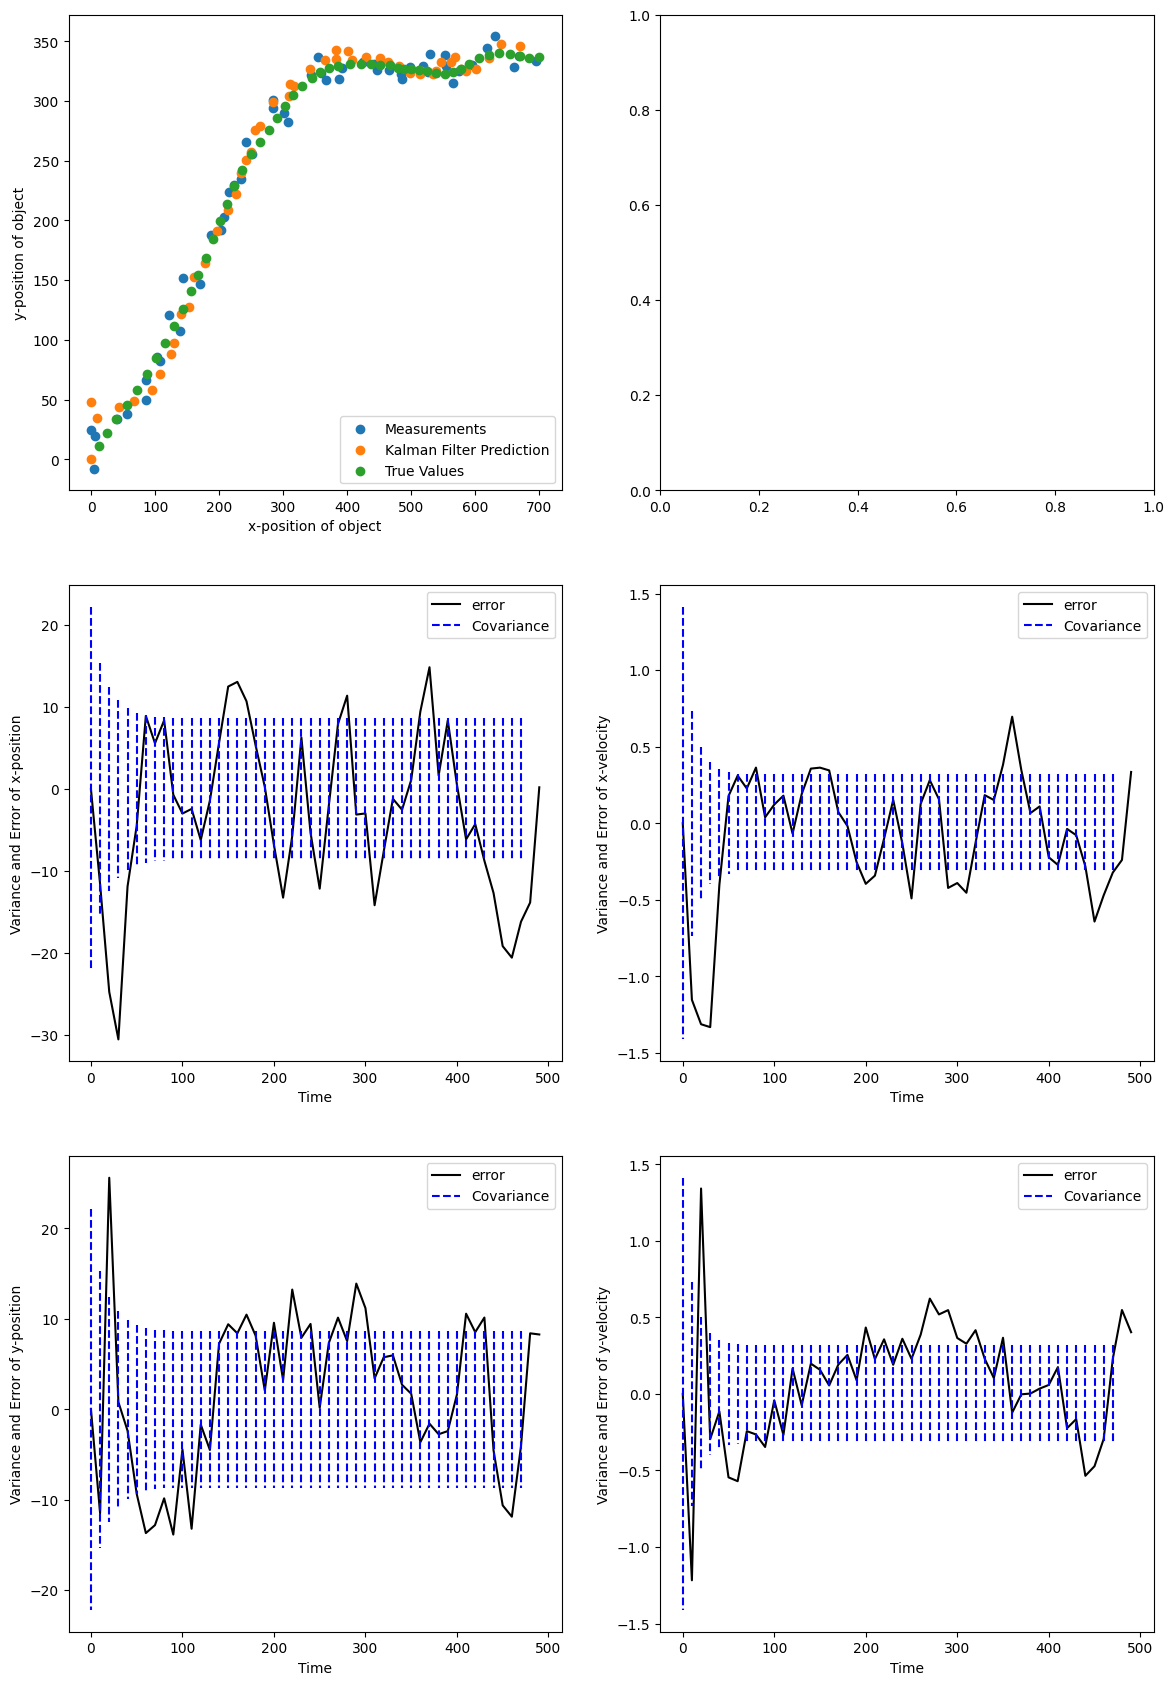

In [26]:
np.random.seed(163)

%run "./Aerospace-Project/Standard Filters/DiffKf.ipynb"
%run "./Aerospace-Project/Standard Filters/KalmanFilter.ipynb"

In [8]:
# Bhattacharya Distance
import numpy as np

def bhattacharyya_distance(mu1, mu2, Sigma1, Sigma2):
    # mu1 = mean of diffusion KF
    # mu2 = mean of centralized KF
    # Sigma1 = covariance of diffusion KF
    # Sigma2 = covariance of centralized KF
    Sigma = (Sigma1 + Sigma2) / 2
    inv_Sigma = np.linalg.inv(Sigma)

    term1 = 1/8 * np.dot(np.dot((mu1 - mu2).T, inv_Sigma), (mu1 - mu2))
    term2 = 1/2 * np.log(np.linalg.det(Sigma) / np.sqrt(np.linalg.det(Sigma1) * np.linalg.det(Sigma2)))

    return term1 + term2

# Example values
mu_diffusion = np.array([1, 2])  # Mean vector from diffusion KF
mu_centralized = np.array([1.1, 2.1])  # Mean vector from centralized KF

Sigma_diffusion = np.array([[1, 0.5], [0.5, 2]])  # Covariance matrix from diffusion KF
Sigma_centralized = np.array([[1.2, 0.3], [0.3, 1.5]])  # Covariance matrix from centralized KF

# Calculate Bhattacharyya Distance
DB = bhattacharyya_distance(mu_diffusion, mu_centralized, Sigma_diffusion, Sigma_centralized)
print("Bhattacharyya Distance: ", DB)

Bhattacharyya Distance:  0.011499896939905723


In [5]:
# Kronecker Product -> no need to formulate.
A = np.array([[1, 2], [3, 4]])
B = np.array([[5, 6], [7, 8]])
C = np.kron(A, B)
print(C)

[[ 5  6 10 12]
 [ 7  8 14 16]
 [15 18 20 24]
 [21 24 28 32]]


EXAMPLE

In [51]:
dt = 10
q = 0.001

C = np.array([[0.34,0.33, 0, 0, 0.33],[0.33,0.34,0.33,0,0],[0,0.33,0.34,0.33,0],[0,0,0.33,0.34,0.33],[0.33,0,0,0.33,0.34]])
num_stns = len(C[0])

A = np.array([[1, dt, 0, 0], [0, 1, 0, 0],[0,0,1,dt], [0, 0, 0, 1]])
H = np.array([[1, 0, 0, 0],[0,0,1,0]])

dkf_state_size = len(A[0])
dkf_measure_size = len(H)

Q = q*np.array([[(dt**3)/3, (dt**2)/2, 0, 0], [(dt**2)/2, dt, 0, 0],[0,0,(dt**3)/3,(dt**2)/2], [0, 0, (dt**2)/2, dt]])
R = np.array([[4,0],[0,4]])

A_kf = np.kron(np.eye(num_stns),A)
H_kf = np.kron(np.eye(num_stns),H)
Q_kf = np.kron(np.eye(num_stns),Q)
R_kf = np.kron(np.eye(num_stns),R)

kf_state_size = A_kf.shape[0]
kf_measure_size = R_kf.shape[0]

F = [A for _ in range(num_stns)]
G = [np.eye(dkf_state_size) for _ in range(num_stns)]
H_n = [H for _ in range(num_stns)]

Q_dkf = [Q for _ in range(num_stns)]
R_dkf = [R for _ in range(num_stns)]

procc_noise_kf = lambda : np.linalg.cholesky(Q_kf) @ np.random.normal(np.array([[0 for _ in range(kf_state_size)]]).T)
measure_noise_kf = lambda : np.linalg.cholesky(R_kf) @ np.random.normal(np.array([[0 for _ in range(kf_measure_size)]]).T)

measure_kf_to_dkf  = lambda z: [np.array([z[dkf_measure_size*i + j] for j in range(dkf_measure_size)]) for i in range(num_stns)]
state_kf_to_dkf = lambda z: [np.array([z[dkf_state_size*i + j] for j in range(dkf_state_size)]) for i in range(num_stns)]

#True Initial
x0_kf = np.array([[np.random.normal(0,2) for _ in range(A_kf.shape[0])]]).T

#Initial Estimate
x_kf = x0_kf + procc_noise_kf()
x_dkf = state_kf_to_dkf(x_kf)

P_kf = 10*np.eye(kf_state_size)
P_dkf = [10*np.eye(dkf_state_size) for _ in range(num_stns)]

kf = KalmanFilter(A = A_kf,H = H_kf, Q = Q_kf, R = R_kf,P=P_kf,x0=x_kf)

dkf = DiffKF(C,F,G,H_n,R_dkf,Q_dkf,x_dkf,P_dkf)

iters = 40

truth = np.zeros((iters+1,kf_state_size,1))
truth[0] = x_kf

measurements = np.zeros((iters+1,kf_measure_size,1))
measurements[0] = (H_kf @ x_kf)+measure_noise_kf()


predictions_kf = np.zeros((iters,kf_state_size,1))
predictions_dkf = np.zeros((iters,num_stns,dkf_state_size,1))

errors_kf = np.zeros((iters,kf_state_size,1))
errors_dkf = np.zeros((iters,num_stns,dkf_state_size,1))

P_hist_kf = np.zeros((iters,kf_state_size,kf_state_size))
P_hist_dkf = np.zeros((iters, num_stns, dkf_state_size,dkf_state_size))

for i in range(iters):
    kf.predict()
    dkf.predict()
    kf.update(measurements[i])
    dkf.update(measure_kf_to_dkf(measurements[i]))

    predictions_dkf[i] = [dkf.nodes[j].x for j in range(num_stns)]
    errors_dkf[i] = [dkf.nodes[j].x-state_kf_to_dkf(truth[i])[j] for j in range(num_stns)]
    P_hist_dkf[i] = [dkf.nodes[j].P for j in range(num_stns)]

    predictions_kf[i] = kf.x
    errors_kf[i] = kf.x-truth[i]
    P_hist_kf[i] = kf.P

    truth[i+1] = A_kf@x0_kf + procc_noise_kf()
    measurements[i+1] = H_kf @ truth[-1] + measure_noise_kf()

In [96]:
def bhattacharyya_distance(mu1, mu2, Sigma1, Sigma2):
    # mu1 = mean of diffusion KF
    # mu2 = mean of centralized KF
    # Sigma1 = covariance of diffusion KF
    # Sigma2 = covariance of centralized KF
    Sigma = (Sigma1 + Sigma2) / 2
    inv_Sigma = np.linalg.inv(Sigma)

    term1 = 1/8 * np.dot(np.dot((mu1 - mu2).T, inv_Sigma), (mu1 - mu2))
    term2 = 1/2 * np.log(np.linalg.det(Sigma) / np.sqrt(np.linalg.det(Sigma1) * np.linalg.det(Sigma2)))

    return term1 + term2

# centralized
mu2 = kf.x
Sigma2 = kf.P

# diffusion
# mu1
n_i1 = np.random.normal(loc=0, scale=1, size=m)
v_i = np.random.normal(loc=0, scale=1, size=m)
tilde_x_i_i1 = truth[0]


S_i = np.sum(np.dot(H_n, np.dot(np.linalg.inv(R_dkf), H_n)))

# compute the state (equation 30)
term1 = np.dot(C.T, np.dot(np.identity(20) - np.dot(P_dkf, S_i), np.dot(np.kron(np.identity(20), F), tilde_x_i_i1)))
term2 = np.dot(np.kron(np.identity(20), G), np.kron(np.ones((20,20)), n_i1))
term3 = np.dot(C.T, np.dot(P_dkf, np.dot(H_n.T, np.dot(np.linalg.inv(R_dkf), v_i))))
mu1 = term1 + term2 - term3

# Sigma1
# compute the covariance (equation 32)
F_chi_i = np.dot(C.T, np.dot(np.identity(2) - np.dot(P_dkf, S_i), np.kron(np.identity(1), F)))
G_i = np.dot(C.T, np.dot(np.identity(2) - np.dot(P_dkf, S_i), np.kron(np.identity(1), G)))
D_i = np.dot(C.T, np.dot(P_dkf, np.dot(H_n.T, np.linalg.inv(R_dkf))))
term1 = np.dot(F, np.dot(P_hist_dkf, F_chi_i.T))
term2 = np.dot(G_i, np.dot(np.kron(np.ones((1, 1)), Q_dkf), G_i.T))
term3 = np.dot(D_i, np.dot(R_dkf, D_i.T))

Sigma1 = term1 + term2 + term3

# compute the Bhattacharya distance
print("The Bhattacharya Distance is: ", bhattacharyya_distance(mu1, mu2, Sigma1, Sigma2))

(5, 2, 2)
[[[0.25 0.  ]
  [0.   0.25]]

 [[0.25 0.  ]
  [0.   0.25]]

 [[0.25 0.  ]
  [0.   0.25]]

 [[0.25 0.  ]
  [0.   0.25]]

 [[0.25 0.  ]
  [0.   0.25]]]
(5, 2, 4)
[array([[1, 0, 0, 0],
       [0, 0, 1, 0]]), array([[1, 0, 0, 0],
       [0, 0, 1, 0]]), array([[1, 0, 0, 0],
       [0, 0, 1, 0]]), array([[1, 0, 0, 0],
       [0, 0, 1, 0]]), array([[1, 0, 0, 0],
       [0, 0, 1, 0]])]
(5, 2, 5, 4)
(5, 80, 80)
(20, 100)


ValueError: shapes (5,80,80) and (20,100) not aligned: 80 (dim 2) != 20 (dim 0)